In [26]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
base_path = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment3/q3/"
fig_path = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment3/q3/Figures/b/"
# base_path = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment3/"
# base_path = "/content/gdrive/My Drive/Deep_Learning_Assignments/Assignment3/q3/"
repo_path = base_path+"Repo_folder"
# source_dataset_path = "/content/"+'data/MNIST'
source_dataset_path = "/content/"+'data/MNIST'
target_dataset_path = "/content/" + 'mnist_m'
model_root = base_path +'models'
tar_file_path = base_path + "mnist_m.tar.gz"

In [0]:
# !pip install -q torch==1.0.0 torchvision

In [0]:
# !ls

In [0]:
# %cd "/content/drive/My Drive/Deep_Learning_Assignments/Assignment3/q3/"

In [0]:
# !wget https://drive.google.com/file/d/0B_tExHiYS-0veklUZHFYT19KYjg/
# pip install gdown
# !gdown https://drive.google.com/uc?id=0B_tExHiYS-0veklUZHFYT19KYjg

In [0]:
!tar -xf '/content/drive/My Drive/Deep_Learning_Assignments/Assignment3/q3/mnist_m.tar.gz'

In [0]:
import random
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
# from data_loader import GetLoader
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
# from model import CNNModel
import numpy as np
# from test import test

## GetLoader Class

In [0]:
import torch.utils.data as data
from PIL import Image
import os


class GetLoader(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

In [35]:
# source_dataset_path
# target_dataset_path 
source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
# source_image_root = os.path.join('data', source_dataset_name)
# source_image_root = os.path.join('data', source_dataset_name)
# target_image_root = target_dataset_name

source_image_root = source_dataset_path
target_image_root = target_dataset_path


# cuda = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)


# cudnn.benchmark = True
lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 4

manual_seed = 42
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# load data

img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset_source = datasets.MNIST(
    root='./data',
    train=True,
    transform=img_transform_source,
    download=True
)

dataloader_source = torch.utils.data.DataLoader(
    dataset=dataset_source,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')

dataset_target_train = GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

dataloader_target = torch.utils.data.DataLoader(
    dataset=dataset_target_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

cuda:0


In [0]:
# load model
# !ls
# !cd dataset
# %cd dataset
# !ls
# %cd '..'
# !ls
# !pwd

#ReverseLayerF

In [0]:
from torch.autograd import Function


class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

#DANN Architecture

In [0]:
#Original
class r_DANN(nn.Module):
  def __init__(self, adversarial_representation=True):
    super(r_DANN, self).__init__()
    self.adversarial_representation = adversarial_representation
    # self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
    # self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
    # self.dropout1 = nn.Dropout2d(p=0.25)
    # self.dropout2 = nn.Dropout2d(p=0.5)
    # self.fc1 = nn.Linear(9216, 128)
    # self.fc2 = nn.Linear(128, num_classes)
    self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, stride=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
    self.lc = nn.Sequential(
            nn.Linear(4*4*48,100),
            nn.ReLU(True),            
            nn.Linear(100,100),
            nn.ReLU(True),            
            nn.Linear(100,10),
            nn.LogSoftmax(dim=1)
            )
    self.dc = nn.Sequential(
            nn.Linear(4*4*48,100),
            nn.ReLU(True),            
            nn.Linear(100,2),
            nn.LogSoftmax(dim=1)
            )

  def forward(self,x,alpha):
    x = x.expand(x.data.shape[0], 3, 28, 28)
    feature = self.feature(x)
    feature = feature.view(-1, 4*4*48)
    if self.adversarial_representation:
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        domain_output = self.dc(reverse_feature)
    else:
        domain_output = self.dc(feature)
    class_output = self.lc(feature)
    return class_output,domain_output

  def forward1(self,x,alpha=0):
    x = x.expand(x.data.shape[0], 3, 28, 28)
    print("x_shape",x.shape)
    feature = self.feature(x)
    print("f",feature.shape)
    feature = feature.view(-1, 4*4*48)
    # if self.adversarial_representation:
    #     reverse_feature = ReverseLayerF.apply(feature, alpha)
    #     domain_output = self.dc(reverse_feature)
    # else:
    #     domain_output = self.dc(feature)
    # class_output = self.lc(feature)
    return feature    

#DANN Architecture

In [0]:
# #attempt to replicate paper
# class DANN(nn.Module):
#     def __init__(self):
#         super(DANN, self).__init__()
#         self.feature = nn.Sequential()
#         self.feature.add_module('f_conv1', nn.Conv2d(3, 32, kernel_size=5))
#         self.feature.add_module('f_relu1', nn.ReLU(True))
#         self.feature.add_module('f_pool1', nn.MaxPool2d(2))
#         self.feature.add_module('f_conv2', nn.Conv2d(32, 48, kernel_size=5))
#         self.feature.add_module('f_relu2', nn.ReLU(True))
#         self.feature.add_module('f_pool2', nn.MaxPool2d(2))

#         self.class_classifier = nn.Sequential()
#         self.class_classifier.add_module('c_fc1', nn.Linear(48 * 4 * 4, 100))
#         self.class_classifier.add_module('c_relu1', nn.ReLU(True))
#         self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
#         self.class_classifier.add_module('c_relu2', nn.ReLU(True))
#         self.class_classifier.add_module('c_fc3', nn.Linear(100, 10))
#         self.class_classifier.add_module('c_softmax', nn.LogSoftmax(dim=1))

#         self.domain_classifier = nn.Sequential()
#         self.domain_classifier.add_module('d_fc1', nn.Linear(48 * 4 * 4, 100))
#         self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
#         self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
#         self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

#     def forward(self, x, alpha):
#         x = x.expand(x.data.shape[0], 3, 28, 28)
#         feature = self.feature(x) 
#         feature = feature.view(-1, 50 * 4 * 4)
#         reverse_feature = ReverseLayerF.apply(feature, alpha)
#         class_output = self.class_classifier(feature)
#         domain_output = self.domain_classifier(reverse_feature)

#         # return class_output, domain_output,feature
#         return class_output, domain_output

#     def forward1(self, x, alpha=0):
#         x = x.expand(x.data.shape[0], 3, 28, 28)
#         feature = self.feature(x) 
#         feature = feature.view(-1, 50 * 4 * 4)
#         reverse_feature = ReverseLayerF.apply(feature, alpha)
#         class_output = self.class_classifier(feature)
#         domain_output = self.domain_classifier(reverse_feature)

#         return feature
#         # return class_output, domain_output        

#Source-only Architecture

In [0]:
#my CNN
class r_CNN(nn.Module):
  def __init__(self):
    super(r_CNN, self).__init__()
    # self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
    # self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
    # self.dropout1 = nn.Dropout2d(p=0.25)
    # self.dropout2 = nn.Dropout2d(p=0.5)
    # self.fc1 = nn.Linear(9216, 128)
    # self.fc2 = nn.Linear(128, num_classes)
    self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
    self.lc = nn.Sequential(
            nn.Linear(4*4*48,100),
            nn.ReLU(),            
            nn.Linear(100,100),
            nn.ReLU(),            
            nn.Linear(100,10),
            nn.LogSoftmax(dim=1)
            )

  def forward(self,x):
    x = x.expand(x.data.shape[0], 3, 28, 28)
    feature = self.feature(x)
    feature = feature.view(-1, 4*4*48)
    class_output = self.lc(feature)
    return class_output

  def forward1(self,x):
    x = x.expand(x.data.shape[0], 3, 28, 28)
    feature = self.feature(x)
    feature = feature.view(-1, 4*4*48)
    return feature

#Loading Models

In [0]:
train_dann =False
dann = r_DANN()
cnn= r_CNN()

# setup optimizer

if(train_dann):
    optimizer = optim.Adam(dann.parameters(), lr=lr)
else:
    optimizer = optim.Adam(cnn.parameters(), lr=lr)

loss_class = torch.nn.NLLLoss()
loss_domain = torch.nn.NLLLoss()

# if cuda:
dann = dann.to(device)
cnn = cnn.to(device)
  # loss_class = loss_class.cuda()
  # loss_domain = loss_domain.cuda()
loss_class = loss_class.to(device)    
loss_domain = loss_domain.to(device)    

for p in dann.parameters():
    p.requires_grad = True

for p in cnn.parameters():
    p.requires_grad = True    

#Training on CNN

In [0]:
# # training model
# for epoch in range(num_epochs):
#   for i ,(img_batch,label_batch) in enumerate(train_loader):
    
#     if torch.cuda.is_available():
#       img_batch = img_batch.cuda()  
#       label_batch = label_batch.cuda()
    
#     optim.zero_grad()
#     outputs = cnn_model(img_batch)
#     loss = F.nll_loss(outputs, label_batch)
    
#     loss.backward()
#     optim.step()
    
#     if (i+1) % 100 == 0:
#      test_loss = 0
#      correct = 0
#      with torch.no_grad():
#         for img_batch, label_batch in test_loader:
#           if(torch.cuda.is_available()):
#             img_batch = img_batch.cuda()
#             label_batch = label_batch.cuda()

#             logits = cnn_model(img_batch)
#             test_loss += F.nll_loss(logits, label_batch, reduction='sum').item()  # sum up batch loss
#             pred = logits.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(label_batch.view_as(pred)).sum().item()
#      print('Epoch: '+str(epoch)+', Iteration: '+str(i)+', Loss: '+str(loss.item())+' Test Accuracy: '+str(correct / len(test_loader.dataset)))

#Test_dataloaders

In [0]:
batch_size = 128
image_size = 28
alpha = 0

"""load data"""

img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# source_dataset_path
# target_dataset_path    

    # if dataset_name == 'mnist_m':
test_list = os.path.join(target_dataset_path, 'mnist_m_test_labels.txt')

target_test_dataset = GetLoader(
    data_root=os.path.join(target_dataset_path, 'mnist_m_test'),
    data_list=test_list,
    transform=img_transform_target
)
# else:
source_test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=img_transform_source,
)

# source_test_dataloader
# target_test_dataloader

source_test_dataloader = torch.utils.data.DataLoader(
    dataset=source_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

target_test_dataloader = torch.utils.data.DataLoader(
    dataset= target_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)    

#Testing Functions

In [0]:
import os
# import torch.backends.cudnn as cudnn
import torch.utils.data
from torchvision import transforms
# from data_loader import GetLoader
from torchvision import datasets




def test_dann(dataset_name, epoch):
    assert dataset_name in ['MNIST', 'mnist_m']

    batch_size = 128
    image_size = 28
    alpha = 0

    model_root = base_path+'models'
    if(dataset_name=="MNIST"):
        dataloader = source_test_dataloader
    else:
        dataloader = target_test_dataloader        

    """ Dataloader built"""

    # """ training """

    dann = torch.load(os.path.join(
        model_root, 'newdann_mnist_mnistm_model_epoch_' + str(epoch) + '.pth'
    ))
    # print(dann)
    dann = dann.eval()


    # if cuda:
    dann = dann.to(device)

    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    i = 0
    n_total = 0
    n_correct = 0
    domain_correct =0

    while i < len_dataloader:

        # test model using target data
        data_target = data_target_iter.next()
        t_img, t_label = data_target

        batch_size = len(t_label)
        # print("bs",batch_size)
        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)


        if(dataset_name=="MNIST"):
            domain_label = torch.zeros(batch_size)
            domain_label = domain_label.long()
        else:
            domain_label = torch.ones(batch_size)
            domain_label = domain_label.long()          


        # if cuda:
        t_img = t_img.to(device)
        t_label = t_label.to(device)
        input_img = input_img.to(device)
        class_label = class_label.to(device)
        domain_label = domain_label.to(device)            

        input_img.resize_as_(t_img).copy_(t_img)
        class_label.resize_as_(t_label).copy_(t_label)

        class_output, domain_output = dann(x=input_img, alpha=alpha)
        #new code
        # if(i==0):
        #     # print("DO", domain_output)
        domain_pred = domain_output.data.max(1, keepdim=True)[1]
        domain_correct += domain_pred.eq(domain_label.data.view_as(domain_pred)).cpu().sum()
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(class_label.data.view_as(pred)).cpu().sum()
        n_total += batch_size

        i += 1

    accu = n_correct.data.numpy() * 1.0 / n_total
    accu_domain = domain_correct.data.numpy() * 1.0 / n_total
    print ('epoch: %d, accuracy of the %s dataset: %f' % (epoch, dataset_name, accu))
    print ('epoch: %d, Domain accuracy of the %s dataset: %f' % (epoch, dataset_name, accu_domain))
    return accu,accu_domain


In [0]:
#testing for cnn
def test_cnn(dataset_name, epoch):
    assert dataset_name in ['MNIST', 'mnist_m']

    model_root = base_path+'models'

    batch_size = 128
    image_size = 28
    alpha = 0

    if(dataset_name=="MNIST"):
        dataloader = source_test_dataloader
    else:
        dataloader = target_test_dataloader        

    cnn = torch.load(os.path.join(
        model_root, 'r_cnn_mnist_mnistm_model_epoch_' + str(epoch) + '.pth'
    ))
    cnn = cnn.eval()

    # if cuda:
    cnn = cnn.to(device)

    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    i = 0
    n_total = 0
    n_correct = 0

    while i < len_dataloader:

        # test model using target data
        data_target = data_target_iter.next()
        t_img, t_label = data_target

        batch_size = len(t_label)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)

        # if cuda:
        t_img = t_img.to(device)
        t_label = t_label.to(device)
        input_img = input_img.to(device)
        class_label = class_label.to(device)

        input_img.resize_as_(t_img).copy_(t_img)
        class_label.resize_as_(t_label).copy_(t_label)

        class_output = cnn(x=input_img)
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(class_label.data.view_as(pred)).cpu().sum()
        n_total += batch_size

        i += 1

    accu = n_correct.data.numpy() * 1.0 / n_total
    return accu
    print ('epoch: %d, accuracy of the %s dataset: %f' % (epoch, dataset_name, accu))

#Training on DANN

In [46]:
# # training
# CUDA_LAUNCH_BLOCKING=1 
n_epoch = 100
best_epoch = 0 
lowest_domain_accu = 1

domain_errs = []
train_errs = []
test_accus = []


for epoch in range(n_epoch):

    len_dataloader = min(len(dataloader_source), len(dataloader_target))
    data_source_iter = iter(dataloader_source)
    data_target_iter = iter(dataloader_target)

    i = 0
    tot_err = 0    
    domain_err = 0
    label_err = 0
    while i < len_dataloader:
        # print("Image",i)
        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # training model using source data
        data_source = data_source_iter.next()
        # print(data_source)
        s_img, s_label = data_source
        assert(s_img!=None)
        assert(data_source!=None)


        dann.zero_grad()
        batch_size = len(s_label)
#          print("s_label",batch_size)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)
        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()

        # if to:device
        s_img = s_img.to(device)
        s_label = s_label.to(device)
        input_img = input_img.to(device)
        class_label = class_label.to(device)
        domain_label = domain_label.to(device)

        input_img.resize_as_(s_img).copy_(s_img)
        class_label.resize_as_(s_label).copy_(s_label)

        class_output, domain_output = dann(x=input_img, alpha=alpha)
        err_s_label = loss_class(class_output, class_label)
        err_s_domain = loss_domain(domain_output, domain_label)
        '''new'''
        err_s_label.to(device)
        err_s_domain.to(device)


        # training model using target data
        data_target = data_target_iter.next()
        t_img, _ = data_target

        batch_size = len(t_img)
        # print("t_label",batch_size)        

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        domain_label = torch.ones(batch_size)
        domain_label = domain_label.long()

        # if to:device
        t_img = t_img.to(device)
        input_img = input_img.to(device)
        domain_label = domain_label.to(device)

        input_img.resize_as_(t_img).copy_(t_img)

        _, domain_output = dann(x=input_img, alpha=alpha)
        err_t_domain = loss_domain(domain_output, domain_label)
        err_t_domain.to(device)#added new
        err = err_t_domain + err_s_domain + err_s_label
        domain_err +=( err_t_domain + err_s_domain )
        tot_err+=err



        
        label_err+= err_s_label
        err.backward()
        optimizer.step()

        i += 1
        if(i%200==0):
            print ('epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' \
                  % (epoch, i, len_dataloader, err_s_label.data.cpu().numpy(),
                    err_s_domain.data.cpu().numpy(), err_t_domain.data.cpu().item()))
            print("total err: ",err.detach().cpu().numpy())
    # torch.save(dann, '{0}/newdann_mnist_mnistm_model_epoch_{1}.pth'.format(model_root, epoch))
    _,da1 = test_dann(source_dataset_name, epoch)
    accu,da2 = test_dann(target_dataset_name, epoch)
    domain_accu = (da1+da2)/2
    
    domain_err = domain_err.detach().cpu().numpy()/len_dataloader
    tot_err = tot_err.detach().cpu().numpy()/len_dataloader    
    domain_accu = (da1+da2)/2
    domain_errs.append(domain_err)
    test_accus.append(accu)
    train_errs.append(tot_err) # train errs list
    
    
    if(domain_accu<lowest_domain_accu and accu>65):
        best_epoch = epoch
        lowest_domain_accu = domain_accu
    # print(" label err: ",label_err.detach().cpu().numpy(),"domain err: ",domain_err.detach().cpu().numpy(), " domain accuracy: ", domain_accu)
    print(" label err: ",label_err,"domain err: ",domain_err, " domain accuracy: ", domain_accu)

print('done')

epoch: 0, [iter: 200 / all 461], err_s_label: 2.295856, err_s_domain: 0.657707, err_t_domain: 0.716516
total err:  3.6700783
epoch: 0, [iter: 400 / all 461], err_s_label: 2.315053, err_s_domain: 0.651621, err_t_domain: 0.715094
total err:  3.6817672
epoch: 0, accuracy of the MNIST dataset: 0.981300
epoch: 0, Domain accuracy of the MNIST dataset: 0.998900
epoch: 0, accuracy of the mnist_m dataset: 0.543606
epoch: 0, Domain accuracy of the mnist_m dataset: 0.999000
 label err:  tensor(1064.3848, device='cuda:0', grad_fn=<AddBackward0>) domain err:  1.3722932695566703  domain accuracy:  0.9989500555493834
epoch: 1, [iter: 200 / all 461], err_s_label: 2.295563, err_s_domain: 0.661324, err_t_domain: 0.716273
total err:  3.6731606
epoch: 1, [iter: 400 / all 461], err_s_label: 2.317984, err_s_domain: 0.652536, err_t_domain: 0.717028
total err:  3.6875482
epoch: 1, accuracy of the MNIST dataset: 0.971800
epoch: 1, Domain accuracy of the MNIST dataset: 0.990000
epoch: 1, accuracy of the mnist_m

KeyboardInterrupt: ignored

ValueError: ignored

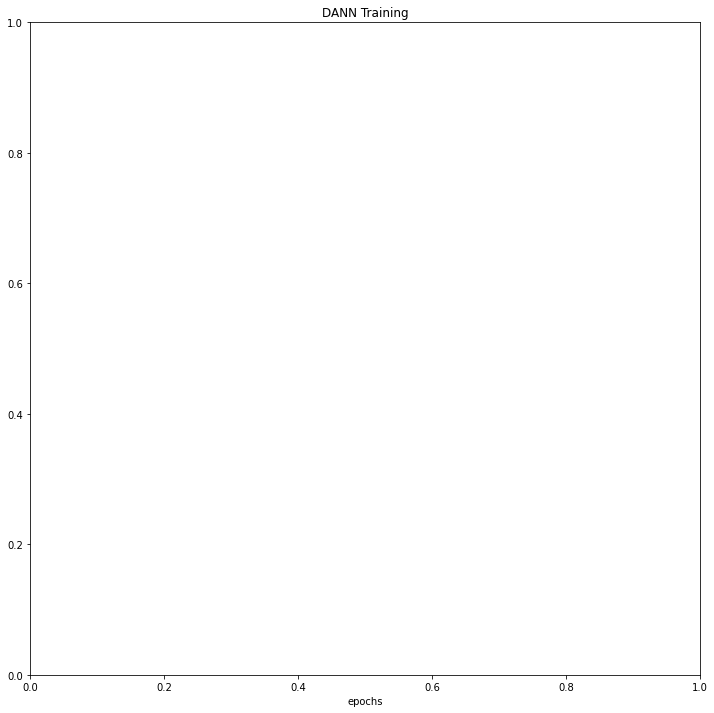

In [47]:
fig_width = 12
fig_height = 12
fig_dims = [fig_width,fig_height]
mode = "DANN"
import matplotlib.pyplot as plt
epochs = np.arange(1,n_epoch+1)
plt.figure(1,figsize = fig_dims)
plt.title("DANN Training")
plt.xlabel('epochs' )
plt.plot(epochs,domain_errs,'r',label="domain classification error")
plt.plot(epochs,train_errs,'g', label = "Total Training error")
plt.plot(epochs,test_accus,'b',label = "Test Label classification accuracy")
plt.legend(loc="upper left")
save_name = "DANN_training_plot"
fig_name = fig_path + str(mode) + '_' + str(save_name) + '.png'
plt.savefig(fig_name)

#Training for CNN

In [48]:
# training for cnn
n_epoch = 100
CUDA_LAUNCH_BLOCKING=1 

train_errs = []
test_accus = []


for epoch in range(n_epoch):

    len_dataloader = min(len(dataloader_source), len(dataloader_target))
    data_source_iter = iter(dataloader_source)
    data_target_iter = iter(dataloader_target)

    i = 0
    tot_err = 0
    label_err = 0
    while i < len_dataloader:
        # p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
        # alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # training model using source data
        data_source = data_source_iter.next()
        # print(data_source)
        s_img, s_label = data_source
        assert(s_img!=None)
        assert(data_source!=None)


        cnn.zero_grad()
        batch_size = len(s_label)
        # print("s_label",batch_size)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)
        # domain_label = torch.zeros(batch_size)
        # domain_label = domain_label.long()

        # if to:device
        s_img = s_img.to(device)
        s_label = s_label.to(device)
        input_img = input_img.to(device)
        class_label = class_label.to(device)
        # domain_label = domain_label.to(device)

        input_img.resize_as_(s_img).copy_(s_img)
        class_label.resize_as_(s_label).copy_(s_label)

        class_output = cnn(x=input_img)
        err_s_label = loss_class(class_output, class_label)
        # err_s_domain = loss_domain(domain_output, domain_label)
        '''new'''
        # err_s_label.to(device)
        # err_s_domain.to(device)


        err = err_s_label
        tot_err+=err
        err.backward()
        optimizer.step()

        i += 1
        if(i%200==0):
          print ('epoch: %d, [iter: %d / all %d], err_s_label: %f' \
                % (epoch, i, len_dataloader, err_s_label.data.cpu().numpy(),
                  ))

    # torch.save(cnn, '{0}/r_cnn_mnist_mnistm_model_epoch_{1}.pth'.format(model_root, epoch))
    print(" label err: ",tot_err.detach().cpu().numpy())
    tot_err = tot_err.detach().cpu().numpy()/len_dataloader    
    train_errs.append(tot_err)
    test_cnn(source_dataset_name, epoch)
    test_accu = test_cnn(target_dataset_name, epoch)
    test_accus.append(test_accu)
print('done')

epoch: 0, [iter: 200 / all 461], err_s_label: 0.114265
epoch: 0, [iter: 400 / all 461], err_s_label: 0.081265
 label err:  89.47624
epoch: 1, [iter: 200 / all 461], err_s_label: 0.128788
epoch: 1, [iter: 400 / all 461], err_s_label: 0.042122
 label err:  22.90698
epoch: 2, [iter: 200 / all 461], err_s_label: 0.030180
epoch: 2, [iter: 400 / all 461], err_s_label: 0.036672
 label err:  17.108105
epoch: 3, [iter: 200 / all 461], err_s_label: 0.041814
epoch: 3, [iter: 400 / all 461], err_s_label: 0.015336
 label err:  13.3289585
epoch: 4, [iter: 200 / all 461], err_s_label: 0.021585
epoch: 4, [iter: 400 / all 461], err_s_label: 0.000991
 label err:  10.465717
epoch: 5, [iter: 200 / all 461], err_s_label: 0.093823
epoch: 5, [iter: 400 / all 461], err_s_label: 0.036179
 label err:  9.069322
epoch: 6, [iter: 200 / all 461], err_s_label: 0.021835
epoch: 6, [iter: 400 / all 461], err_s_label: 0.026990
 label err:  7.9717917
epoch: 7, [iter: 200 / all 461], err_s_label: 0.000564
epoch: 7, [iter:

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f57836b31d0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f57836b31d0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    self._shutdown_workers()
    w.join()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    w.join()
    assert self._p

epoch: 53, [iter: 200 / all 461], err_s_label: 0.138197
epoch: 53, [iter: 400 / all 461], err_s_label: 0.000050
 label err:  1.7733079


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f57836b31d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f57836b31d0>>
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f57836b31d0>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f57836b31d0>>
Traceback (most recent call l

epoch: 54, [iter: 200 / all 461], err_s_label: 0.000003
epoch: 54, [iter: 400 / all 461], err_s_label: 0.002783
 label err:  0.54157794


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f57836b31d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f57836b31d0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f57836b31d0>>
Traceback (most recent call last):
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f57836b31d0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/datalo

epoch: 55, [iter: 200 / all 461], err_s_label: 0.001577
epoch: 55, [iter: 400 / all 461], err_s_label: 0.000030
 label err:  0.94881
epoch: 56, [iter: 200 / all 461], err_s_label: 0.000002
epoch: 56, [iter: 400 / all 461], err_s_label: 0.000476
 label err:  0.58179235
epoch: 57, [iter: 200 / all 461], err_s_label: 0.009990
epoch: 57, [iter: 400 / all 461], err_s_label: 0.044742
 label err:  2.0834453
epoch: 58, [iter: 200 / all 461], err_s_label: 0.000002
epoch: 58, [iter: 400 / all 461], err_s_label: 0.000003
 label err:  1.6676421
epoch: 59, [iter: 200 / all 461], err_s_label: 0.000000
epoch: 59, [iter: 400 / all 461], err_s_label: 0.000005
 label err:  1.0035648
epoch: 60, [iter: 200 / all 461], err_s_label: 0.001457
epoch: 60, [iter: 400 / all 461], err_s_label: 0.000009
 label err:  1.9984398
epoch: 61, [iter: 200 / all 461], err_s_label: 0.002430
epoch: 61, [iter: 400 / all 461], err_s_label: 0.000015
 label err:  1.3875439
epoch: 62, [iter: 200 / all 461], err_s_label: 0.002526


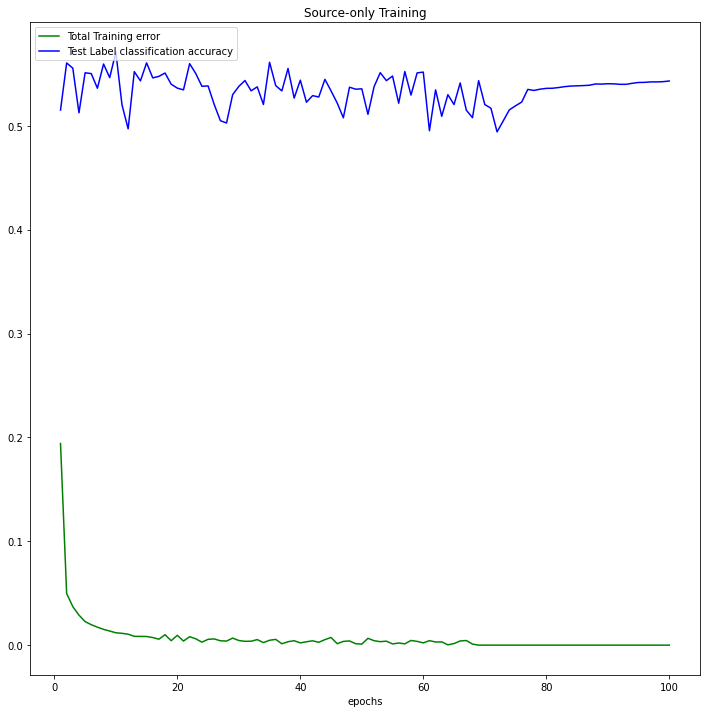

In [49]:
fig_width = 12
fig_height = 12
fig_dims = [fig_width,fig_height]
mode = "Source-only"
import matplotlib.pyplot as plt
epochs = np.arange(1,n_epoch+1)
plt.figure(1,figsize = fig_dims)
plt.title("Source-only Training")
plt.xlabel('epochs' )
plt.plot(epochs,train_errs,'g', label = "Total Training error")
plt.plot(epochs,test_accus,'b',label = "Test Label classification accuracy")
plt.legend(loc="upper left")
save_name = "Source-only_training_plot"
fig_name = fig_path + str(mode) + '_' + str(save_name) + '.png'
plt.savefig(fig_name)

#Testing Best Models

In [0]:
# r_cnn_mnist_mnistm_model_epoch_40.pth
# newdann_mnist_mnistm_model_epoch_98.pth
test_cnn(source_dataset_name, epoch = 40)
test_cnn(target_dataset_name, epoch = 40)

test_dann(source_dataset_name, epoch = 98)
test_dann(target_dataset_name, epoch = 98)

NameError: ignored

#TSNE

In [0]:
from sklearn.manifold import TSNE
import itertools
import matplotlib.pyplot as plt
import os

In [0]:
def plot_embedding(X, y, d, mode, save_name,fontsize=5):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    y = list(itertools.chain.from_iterable(y))
    y = np.asarray(y)

    plt.figure(figsize=(15, 15))
    for i in range(len(d)):  # X.shape[0] : 1024
        # plot colored number
        if d[i] == 0:
            colors = (0.0, 0.0, 1.0, 1.0)
        else:
            colors = (1.0, 0.0, 0.0, 1.0)
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=colors,
                 fontdict={'weight': 'bold', 'size': fontsize})

    plt.xticks([]), plt.yticks([])
    if save_name is not None:
        plt.title(save_name)

    # save_folder = 'saved_plot'
    # if not os.path.exists(save_folder):
    #     os.makedirs(save_folder)

    fig_name = fig_path + str(mode) + '_' + str(save_name) + '.png'
    plt.savefig(fig_name)
    print('{} is saved'.format(fig_name))

In [0]:

def gen_tsne(mode,epoch,num_batches=4):
  # mode: 'cnn' or 'dann'
  batch_size = 128
  if(mode=="dann"):
      model = torch.load(os.path.join(
          model_root, 'newdann_mnist_mnistm_model_epoch_' + str(epoch) + '.pth'
      ))
  else:
      model = torch.load(os.path.join(
          model_root, 'r_cnn_mnist_mnistm_model_epoch_' + str(epoch) + '.pth'
      ))
  # if to:device
  model = model.eval()  
  model = model.to(device)

  source_test_loader = source_test_dataloader
  target_test_loader = target_test_dataloader


  # num_batches = 40

  num_samples = num_batches*batch_size
  print(batch_size,num_samples)

  # Get source_test samples
  source_label_list = []
  source_img_list = []
  for i, test_data in enumerate(source_test_loader):
      if i >= num_batches:  # to get only 10,240 samples , as 128 batch size
          break
      img, label = test_data
      label = label.numpy()
      img = img.to(device)
      img = torch.cat((img, img, img), 1)  # MNIST channel 1 -> 3
      source_label_list.append(label)
      source_img_list.append(img)

  source_img_list = torch.stack(source_img_list)
  source_img_list = source_img_list.view(-1, 3, 28, 28)

  # Get target_test samples
  target_label_list = []
  target_img_list = []
  for i, test_data in enumerate(target_test_loader):
      if i >= num_batches:
          break
      img, label = test_data
      label = label.numpy()
      img = img.to(device)
      target_label_list.append(label)
      target_img_list.append(img)

  target_img_list = torch.stack(target_img_list)
  target_img_list = target_img_list.view(-1, 3, 28, 28)

  print("ns",num_samples)

  # Stack source_list + target_list
  combined_label_list = source_label_list
  combined_label_list.extend(target_label_list)
  combined_img_list = torch.cat((source_img_list, target_img_list), 0)

  source_domain_list = torch.zeros(num_samples).type(torch.LongTensor)
  target_domain_list = torch.ones(num_samples).type(torch.LongTensor)
  combined_domain_list = torch.cat((source_domain_list, target_domain_list), 0).to(device)

  print("Extract features to draw T-SNE plot for "+str(num_samples)+" ...")
  #  = encoder()  # combined_feature : 1024,2352
  
  combined_feature = model.forward1(combined_img_list)

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000)
  model_tsne = tsne.fit_transform(combined_feature.detach().cpu().numpy())
  print('Draw plot ...')
  save_name = str(epoch)
  save_name = save_name + '_rnew_' + str(mode)
  plot_embedding(model_tsne, combined_label_list, combined_domain_list, mode, save_name)
  return model_tsne,combined_label_list,combined_domain_list,mode,save_name
  # fashion_scatter(model_tsne,combined_label_list)


128 5120
ns 5120
Extract features to draw T-SNE plot for 5120 ...
Draw plot ...
/content/drive/My Drive/Deep_Learning_Assignments/Assignment3/q3/Figures/b/cnn_40_rnew_cnn.png is saved
CPU times: user 4min 54s, sys: 1.26 s, total: 4min 55s
Wall time: 4min 59s


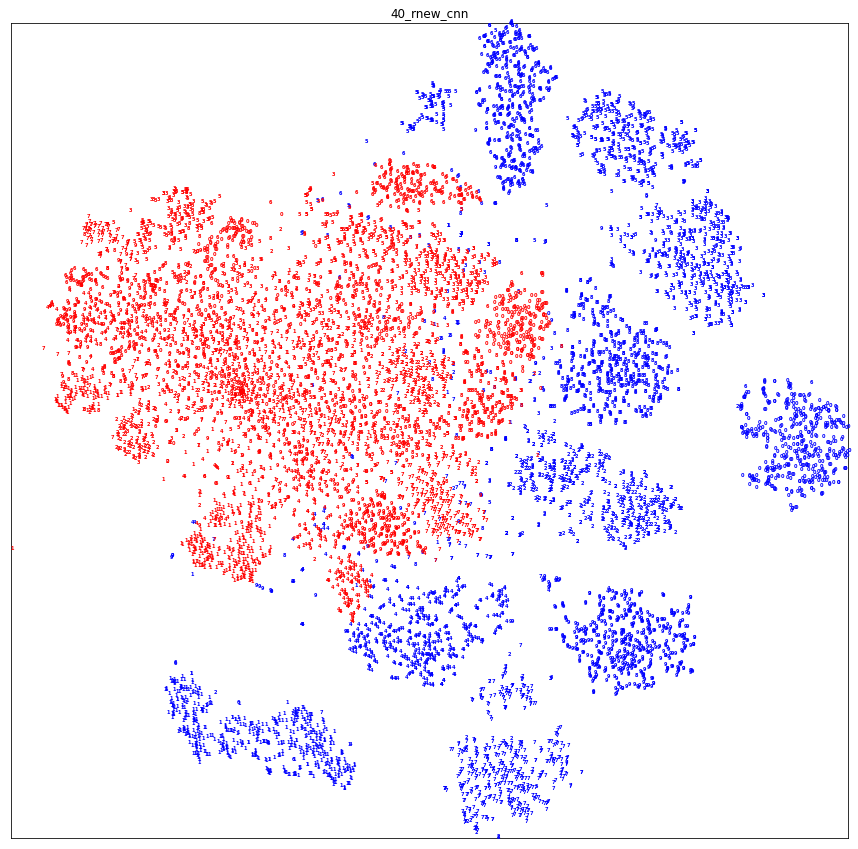

In [0]:
%%time
# test_dann('mnist_m',29)
# test_dann('MNIST',29)
# test_cnn('mnist_m',11)
# test_cnn('MNIST',11)
# print(best_epoch)
# print(batch_size)
model_tsne,combined_label_list,combined_domain_list,mode,save_name = gen_tsne(mode='cnn',epoch = 40,num_batches=40)

/content/drive/My Drive/Deep_Learning_Assignments/Assignment3/q3/Figures/bdann_98_rnew_dann.png is saved


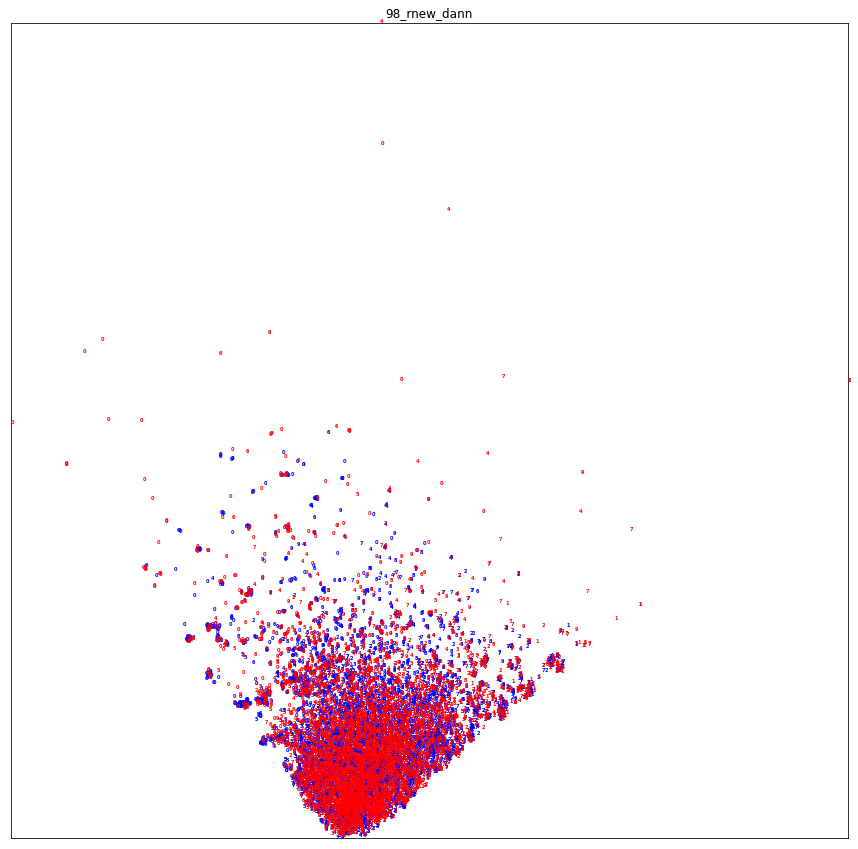

In [0]:
  plot_embedding(model_tsne, combined_label_list, combined_domain_list, mode, save_name)

In [0]:
test_dann('mnist_m',94)
# test_dann('MNIST',97)

DANN(
  (feature): Sequential(
    (f_conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (f_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (f_relu1): ReLU(inplace=True)
    (f_conv2): Conv2d(64, 50, kernel_size=(5, 5), stride=(1, 1))
    (f_bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_drop1): Dropout2d(p=0.5, inplace=False)
    (f_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (f_relu2): ReLU(inplace=True)
  )
  (class_classifier): Sequential(
    (c_fc1): Linear(in_features=800, out_features=100, bias=True)
    (c_bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (c_relu1): ReLU(inplace=True)
    (c_drop1): Dropout2d(p=0.5, inplace=False)
    (c_fc2): Linear(in_features=100, out_features=100, bias=True)
    (c_bn2): B

RuntimeError: ignored